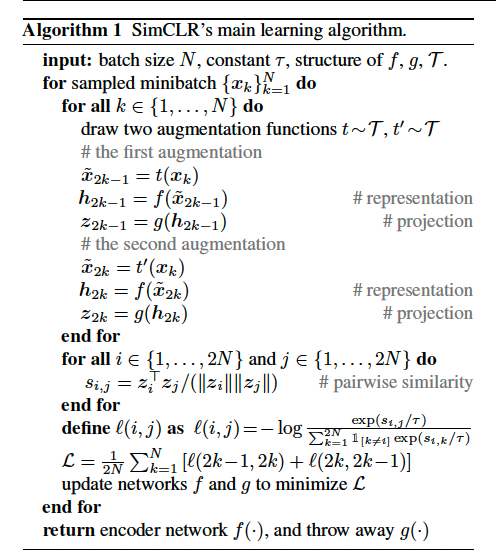

In [1]:
import numpy as np
import torch as tr
import torchvision
import torch

In [2]:
batch_size_train = 16
batch_size_test = 16

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x, 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = self.fc1(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

encoder = Net()

torch.Size([16, 10])

In [47]:
torchvision.transforms.functional.resized_crop?

In [ ]:
# def visualize_batch(x_i,x_j)

IndexError: index 5 is out of bounds for axis 0 with size 5

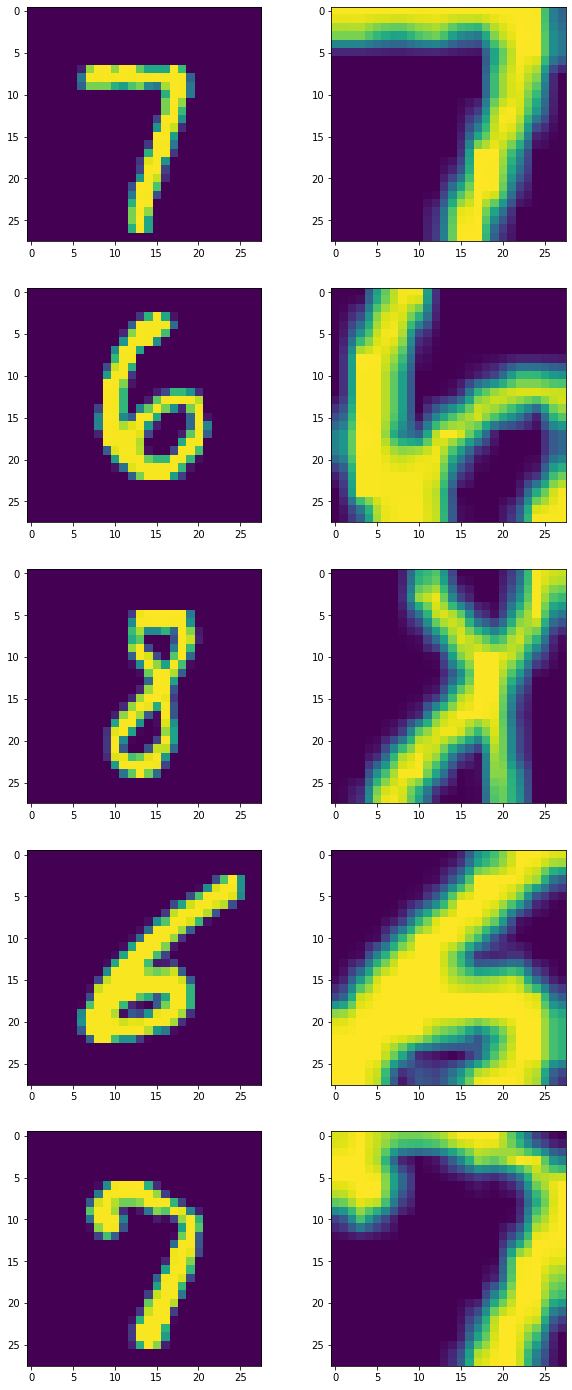

In [63]:
N,C,H,W = x_i.shape
Nplt = np.min([5,N])
fg,axar = plt.subplots(Nplt,2,figsize=(10,5*Nplt))
for ix in range(len(x_i)):
  ax1 = axar[ix,0]
  ax2 = axar[ix,1]
  ax1.imshow(x_i[ix,0])
  ax2.imshow(x_j[ix,0])
  

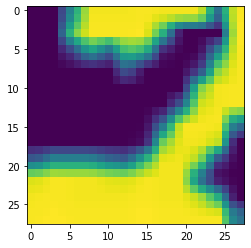

In [46]:
from matplotlib import pyplot as plt
ax = plt.gca()
ax.imshow(x_j[0,0])

In [51]:
for x,y in train_loader:
  x_i = x_i = x
  xj = x_j =  torchvision.transforms.functional.resized_crop(
    x,
    top=8,
    left=8,
    height=12,
    width=12,
    size=(28,28)
  )